In [4]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# interactive mode on
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    
# view reshapes according to the argument

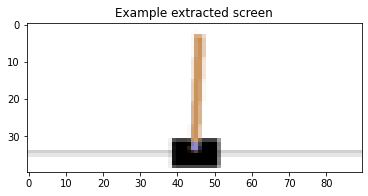

In [7]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [12]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n
# print(n_actions)

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

2


In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [11]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

In [13]:
import torch
x = torch.ones(2,2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [14]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [16]:
z = x * 2
print(z)

tensor([[2., 2.],
        [2., 2.]], grad_fn=<MulBackward0>)


In [35]:
t = x * 2
t2 = t + 3
t3 = x.mean()
print(t, t2)

tensor([[2., 2.],
        [2., 2.]], grad_fn=<MulBackward0>) tensor([[5., 5.],
        [5., 5.]], grad_fn=<AddBackward0>)


In [36]:
print(t.grad_fn)

In [37]:
print(x.grad)

tensor([[1., 1.],
        [1., 1.]])


In [41]:
t3.backward()
print(x.grad)
# d(t3)/ dx

tensor([[1.5000, 1.5000],
        [1.5000, 1.5000]])


In [50]:
import gym
env = gym.make('CartPole-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
#         print(observation)
        action = env.action_space.sample()
#         print(env.action_space)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

Episode finished after 28 timesteps
Episode finished after 13 timesteps
Episode finished after 13 timesteps
Episode finished after 29 timesteps
Episode finished after 15 timesteps
Episode finished after 18 timesteps
Episode finished after 12 timesteps
Episode finished after 57 timesteps
Episode finished after 29 timesteps
Episode finished after 11 timesteps
Episode finished after 11 timesteps
Episode finished after 17 timesteps
Episode finished after 41 timesteps
Episode finished after 21 timesteps
Episode finished after 11 timesteps
Episode finished after 10 timesteps
Episode finished after 27 timesteps
Episode finished after 25 timesteps
Episode finished after 11 timesteps
Episode finished after 16 timesteps


In [51]:
import gym
env = gym.make('CartPole-v0')
total_reward_sum = [0] * 20
for i_episode in range(20):
    observation = env.reset()
    total_reward = 0
    for t in range(100):
        env.render()
        print(observation)
        #action = env.action_space.sample()
        sum_obs = observation[0] + observation[1] + observation[2] + observation[3]
        if sum_obs > 0:
            action = 1
        else:
            action = 0
        observation, reward, done, info = env.step(action)
        total_reward += 1
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            print("total reward is"),
            print(total_reward)
            total_reward_sum[i_episode] = total_reward
            if i_episode == 19:
                print("all total reward is"),
                print(total_reward_sum)
            break
        if t == 99:
            print("Episode finished after {} timesteps".format(t+1))
            print("total reward is"),
            print(total_reward)
            total_reward_sum[i_episode] = total_reward
            if i_episode == 19:
                print("all total reward is"),
                print(total_reward_sum)

[ 0.02381014 -0.00281303  0.03076867 -0.04481334]
[ 0.02375388  0.19185451  0.02987241 -0.32763188]
[ 0.02759097 -0.00367971  0.02331977 -0.02568023]
[ 0.02751738  0.19110019  0.02280616 -0.31091525]
[ 0.03133938 -0.00433913  0.01658786 -0.01112807]
[ 0.0312526   0.19054105  0.0163653  -0.29853151]
[ 0.03506342 -0.00481031  0.01039467 -0.00073253]
[ 0.03496721  0.19016103  0.01038002 -0.29011777]
[ 0.03877043 -0.00510738  0.00457766  0.00582074]
[ 0.03866829  0.18994862  0.00469408 -0.28541437]
[ 0.04246726 -0.00523996 -0.00101421  0.00874533]
[ 0.04236246  0.18989652 -0.0008393  -0.28425742]
[ 0.04616039 -0.00521345 -0.00652445  0.00816068]
[ 0.04605612  0.19000146 -0.00636124 -0.28657363]
[ 0.04985615 -0.0050292  -0.01209271  0.00409624]
[ 0.04975557  0.19026407 -0.01201079 -0.29237741]
[ 0.05356085 -0.00468458 -0.01785834 -0.0035066 ]
[ 0.05346716  0.19068887 -0.01792847 -0.30177012]
[ 0.05728093 -0.00417303 -0.02396387 -0.01479494]
[ 0.05719747  0.19128425 -0.02425977 -0.31494139]


[-0.06515919 -0.4236286   0.05869871  0.51696831]
[-0.07363176 -0.22938016  0.06903808  0.24334499]
[-0.07821937 -0.03530877  0.07390498 -0.02678756]
[-0.07892554 -0.23140849  0.07336923  0.28826736]
[-0.08355371 -0.03740532  0.07913457  0.01959671]
[-0.08430182 -0.23356772  0.07952651  0.33616076]
[-0.08897317 -0.03966228  0.08624972  0.06957803]
[-0.08976642  0.15412404  0.08764128 -0.19469494]
[-0.08668394 -0.04213513  0.08374739  0.12429751]
[-0.08752664  0.15169339  0.08623334 -0.14083333]
[-0.08449277  0.34548124  0.08341667 -0.40511379]
[-0.07758315  0.14928151  0.07531439 -0.08734146]
[-0.07459752  0.34324763  0.07356756 -0.35534436]
[-0.06773257  0.14716099  0.06646068 -0.04040061]
[-0.06478935  0.34127006  0.06565266 -0.31139637]
[-0.05796394  0.53539823  0.05942474 -0.58267326]
[-0.04725598  0.33949628  0.04777127 -0.27187843]
[-0.04046605  0.53390516  0.0423337  -0.54911967]
[-0.02978795  0.33821491  0.03135131 -0.24340488]
[-0.02302365  0.53287535  0.02648321 -0.52603628]


[-0.01444635  0.56685543 -0.00267117 -0.63184521]
[-0.00310924  0.37177085 -0.01530807 -0.34000471]
[ 0.00432617  0.56710723 -0.02210817 -0.63747535]
[ 0.01566832  0.37230044 -0.03485768 -0.35183584]
[ 0.02311433  0.56790031 -0.04189439 -0.65530349]
[ 0.03447233  0.3733859  -0.05500046 -0.37610124]
[ 0.04194005  0.17908652 -0.06252249 -0.10125487]
[ 0.04552178  0.3750462  -0.06454758 -0.4129897 ]
[ 0.0530227   0.18089576 -0.07280738 -0.14133432]
[ 0.05664062  0.37698085 -0.07563406 -0.45606919]
[ 0.06418024  0.18300518 -0.08475545 -0.18815274]
[ 0.06784034 -0.01080837 -0.0885185   0.07663573]
[ 0.06762417  0.18546371 -0.08698579 -0.24261018]
[ 0.07133345 -0.008315   -0.09183799  0.02141731]
[ 0.07116715 -0.20200809 -0.09140965  0.28377015]
[ 0.06712699 -0.00570934 -0.08573424 -0.0362857 ]
[ 0.0670128  -0.19950389 -0.08645996  0.22816343]
[ 0.06302272 -0.0032596  -0.08189669 -0.09049101]
[ 0.06295753 -0.19711801 -0.08370651  0.17527126]
[ 0.05901517 -0.39094845 -0.08020108  0.44041793]


[ 0.01557367  0.16451294  0.00948082 -0.268652  ]
[ 0.01886393 -0.03074302  0.00410778  0.0270061 ]
[ 0.01824907  0.16431978  0.00464791 -0.26437795]
[ 0.02153547 -0.0308682  -0.00063965  0.02976734]
[ 2.09181026e-02  1.64262916e-01 -4.43064832e-05 -2.63117340e-01]
[ 0.02420336 -0.0308584  -0.00530665  0.02955161]
[ 0.02358619  0.16433925 -0.00471562 -0.26480089]
[ 0.02687298 -0.03071508 -0.01001164  0.02639097]
[ 0.02625868  0.164549   -0.00948382 -0.26943385]
[ 0.02954966 -0.03043633 -0.0148725   0.0202428 ]
[ 0.02894093  0.16489571 -0.01446764 -0.27709522]
[ 0.03223884 -0.03001688 -0.02000955  0.01098973]
[ 0.03163851 -0.22484624 -0.01978975  0.29729285]
[ 0.02714158 -0.02944785 -0.01384389 -0.00156515]
[ 0.02655262 -0.22436855 -0.0138752   0.28671791]
[ 0.02206525 -0.0290515  -0.00814084 -0.01030864]
[ 0.02148422 -0.22405576 -0.00834701  0.27979468]
[ 0.01700311 -0.02881574 -0.00275112 -0.01550914]
[ 0.01642679 -0.22389813 -0.0030613   0.2763045 ]
[ 0.01194883 -0.02873264  0.002464

[ 0.06925546  0.35099005 -0.07750803 -0.31366803]
[ 0.07627526  0.54712566 -0.08378139 -0.62975272]
[ 0.08721777  0.35326659 -0.09637645 -0.36458703]
[ 0.0942831   0.15963699 -0.10366819 -0.10378129]
[ 0.09747584  0.35608006 -0.10574381 -0.4272878 ]
[ 0.10459744  0.16260226 -0.11428957 -0.16972293]
Episode finished after 100 timesteps
total reward is
100
[ 0.01187034  0.00034303 -0.0179512   0.0124559 ]
[ 0.0118772   0.19571776 -0.01770208 -0.28583635]
[ 0.01579156  0.00085269 -0.02341881  0.00121132]
[ 0.01580861 -0.19392571 -0.02339458  0.28641431]
[ 0.0119301   0.00152193 -0.0176663  -0.01355432]
[ 0.01196053 -0.19334227 -0.01793739  0.27350275]
[ 0.00809369  0.00203097 -0.01246733 -0.02478327]
[ 0.00813431 -0.19290999 -0.012963    0.26394014]
[ 0.00427611  0.00239457 -0.00768419 -0.03280309]
[ 0.004324   -0.19261635 -0.00834025  0.25744552]
[ 0.00047167  0.00262367 -0.00319134 -0.03785634]
[ 0.00052415 -0.19245237 -0.00394847  0.25381798]
[-0.0033249   0.00272574  0.00112789 -0.040

[-0.01950968 -0.01302357  0.02155593  0.05949782]
[-0.01977015  0.18178278  0.02274589 -0.22630687]
[-0.01613449 -0.01365673  0.01821975  0.07346328]
[-0.01640763  0.18119934  0.01968902 -0.21341601]
[-0.01278364 -0.01419849  0.0154207   0.08541213]
[-0.01306761  0.18069906  0.01712894 -0.20236593]
[-0.00945363 -0.01466362  0.01308162  0.09567076]
[-0.0097469   0.18026842  0.01499504 -0.19285639]
[-0.00614153 -0.01506479  0.01113791  0.10451886]
[-0.00644283  0.17989579  0.01322829 -0.18462939]
[-0.00284491  0.37482599  0.0095357  -0.47311011]
[ 4.65160866e-03  1.79570677e-01  7.34961008e-05 -1.77436999e-01]
[ 0.00824302  0.37469158 -0.00347524 -0.47009674]
[ 0.01573685  0.17961889 -0.01287718 -0.17851119]
[ 0.01932923  0.37492273 -0.0164474  -0.47522845]
[ 0.02682769  0.18003685 -0.02595197 -0.18777449]
[ 0.03042842 -0.01470438 -0.02970746  0.09660997]
[ 0.03013434  0.18083047 -0.02777526 -0.20529561]
[ 0.03375094 -0.0138835  -0.03188117  0.07849782]
[ 0.03347327  0.18168064 -0.030311

[-0.08186497  0.42428498  0.05614191 -0.46184282]
[-0.07337927  0.22841636  0.04690505 -0.15200574]
[-0.06881095  0.4228364   0.04386494 -0.42953001]
[-0.06035422  0.22712159  0.03527434 -0.12334805]
[-0.05581179  0.42172089  0.03280738 -0.40469691]
[-0.04737737  0.22614941  0.02471344 -0.1018539 ]
[-0.04285438  0.42090863  0.02267636 -0.38663851]
[-0.03443621  0.61570146  0.01494359 -0.67208636]
[-0.02212218  0.420375    0.00150186 -0.37473613]
[-0.01371468  0.61547559 -0.00599286 -0.66694514]
[-0.00140517  0.42043749 -0.01933176 -0.37615514]
[ 0.00700358  0.61582861 -0.02685487 -0.67487023]
[ 0.01932016  0.42108995 -0.04035227 -0.39076196]
[ 0.02774195  0.61676068 -0.04816751 -0.69588946]
[ 0.04007717  0.42233868 -0.0620853  -0.41875049]
[ 0.04852394  0.22814893 -0.07046031 -0.14626842]
[ 0.05308692  0.42420547 -0.07338568 -0.46032171]
[ 0.06157103  0.23019336 -0.08259211 -0.19164286]
[ 0.0661749   0.42639376 -0.08642497 -0.50919473]
[ 0.07470277  0.23258893 -0.09660886 -0.24494982]


[-0.09748668  0.23937687  0.09099682 -0.13195214]
Episode finished after 100 timesteps
total reward is
100
[-0.03852111 -0.01211044  0.02945641 -0.0073057 ]
[-0.03876332 -0.20764218  0.0293103   0.29452362]
[-0.04291616 -0.0129501   0.03520077  0.01122692]
[-0.04317516 -0.20855873  0.03542531  0.31480499]
[-0.04734634 -0.01395884  0.04172141  0.03350117]
[-0.04762551  0.18054075  0.04239143 -0.24573179]
[-0.0440147  -0.01516022  0.0374768   0.06001528]
[-0.0443179   0.17940491  0.0386771  -0.22061189]
[-0.0407298  -0.01624793  0.03426487  0.08401613]
[-0.04105476  0.17836652  0.03594519 -0.19766229]
[-0.03748743 -0.01725064  0.03199194  0.10613951]
[-0.03783245  0.17739859  0.03411473 -0.17628091]
[-0.03428447 -0.01819455  0.03058911  0.12696588]
[-0.03464836  0.17647614  0.03312843 -0.15591175]
[-0.03111884  0.37110849  0.0300102  -0.4379621 ]
[-0.02369667  0.1755749   0.02125095 -0.13597212]
[-0.02018517  0.37038612  0.01853151 -0.42187566]
[-0.01277745  0.17500659  0.010094   -0.123

[ 0.01794715  0.16934267 -0.01383677 -0.22541078]
[ 0.02133401 -0.02557882 -0.01834499  0.06287559]
[ 0.02082243  0.16980128 -0.01708747 -0.23553838]
[ 0.02421846 -0.02507242 -0.02179824  0.05170603]
[ 0.02371701  0.1703552  -0.02076412 -0.24777393]
[ 0.02712411 -0.02446415 -0.0257196   0.03828788]
[ 0.02663483  0.171017   -0.02495384 -0.2623976 ]
[ 0.03005517 -0.02374003 -0.03020179  0.02231133]
[ 0.02958037 -0.21841613 -0.02975557  0.30531433]
[ 0.02521205 -0.02288306 -0.02364928  0.00339772]
[ 0.02475438 -0.217658   -0.02358133  0.2885262 ]
[ 0.02040122 -0.02220785 -0.0178108  -0.01149979]
[ 0.01995707 -0.2170699  -0.0180408   0.27551083]
[ 0.01561567 -0.02169527 -0.01253058 -0.02280714]
[ 0.01518176 -0.2166353  -0.01298672  0.26589605]
[ 0.01084906 -0.02133042 -0.0076688  -0.03085454]
[ 0.01042245 -0.21634156 -0.00828589  0.25939896]
[ 0.00609562 -0.02110231 -0.00309791 -0.03588589]
[ 0.00567357 -0.2161797  -0.00381563  0.25581801]
[ 0.00134998 -0.02100348  0.00130073 -0.03806599]


[ 0.06965187 -0.04229787 -0.04664795 -0.09220198]
[ 0.06880592 -0.23672124 -0.04849199  0.18540631]
[ 0.06407149 -0.43111704 -0.04478386  0.46240618]
[ 0.05544915 -0.23539173 -0.03553574  0.15595052]
[ 0.05074132 -0.42998734 -0.03241673  0.43721435]
[ 0.04214157 -0.23442189 -0.02367244  0.13449144]
[ 0.03745313 -0.4291969  -0.02098261  0.41961306]
[ 0.02886919 -0.23378402 -0.01259035  0.12038982]
[ 0.02419351 -0.42872334 -0.01018255  0.40907416]
[ 0.01561905 -0.62369945 -0.00200107  0.69852955]
[ 0.00314506 -0.42854981  0.01196952  0.40521736]
[-0.00542594 -0.62383944  0.02007387  0.70164978]
[-0.01790273 -0.42900141  0.03410686  0.41535293]
[-0.02648276 -0.23437904  0.04241392  0.13361463]
[-0.03117034 -0.43008206  0.04508621  0.43937111]
[-0.03977198 -0.23562625  0.05387364  0.16123466]
[-0.0444845  -0.43147641  0.05709833  0.47041488]
[-0.05311403 -0.23720553  0.06650663  0.19626124]
[-0.05785814 -0.43321263  0.07043185  0.50916045]
[-0.06652239 -0.23914996  0.08061506  0.239478  ]


[ 0.00242098 -0.18620864 -0.01932944  0.22791293]
[-0.00130319  0.00918413 -0.01477118 -0.07080398]
[-0.00111951 -0.18572297 -0.01618726  0.21718221]
[-0.00483397  0.0096266  -0.01184361 -0.0805626 ]
[-0.00464144 -0.18532358 -0.01345487  0.20836023]
[-0.00834791  0.00998815 -0.00928766 -0.08853646]
[-0.00814815 -0.18499945 -0.01105839  0.20120179]
[-0.01184814 -0.37996151 -0.00703435  0.4903759 ]
[-0.01944737 -0.18474104  0.00277316  0.19548436]
[-0.02314219 -0.37990255  0.00668285  0.4890408 ]
[-0.03074024 -0.18487552  0.01646367  0.19847153]
[-0.03443775 -0.38022903  0.0204331   0.49630219]
[-0.04204233 -0.18540108  0.03035914  0.21012818]
[-0.04575035  0.00927393  0.0345617  -0.07282556]
[-0.04556487 -0.18632603  0.03310519  0.23055828]
[-0.04929139  0.00830761  0.03771636 -0.05150106]
[-0.04912524 -0.18733429  0.03668634  0.25283906]
[-0.05287193  0.00724514  0.04174312 -0.02805032]
[-0.05272702 -0.18844981  0.04118211  0.2775053 ]
[-0.05649602  0.00606117  0.04673222 -0.00190967]


[ 0.01345207  0.03477179 -0.02084953  0.03572956]
[ 0.01414751  0.23018643 -0.02013494 -0.263458  ]
[ 0.01875124  0.03535758 -0.0254041   0.02280676]
[ 0.01945839  0.23083447 -0.02494796 -0.27778195]
[ 0.02407508  0.03607715 -0.0305036   0.00692918]
[ 0.02479662  0.23162298 -0.03036502 -0.29521979]
[ 0.02942908  0.03694679 -0.03626941 -0.01226606]
[ 0.03016802  0.23256962 -0.03651473 -0.31616819]
[ 0.03481941  0.03798629 -0.0428381  -0.0352207 ]
[ 0.03557913 -0.15649601 -0.04354251  0.24364456]
[ 0.03244921  0.03921996 -0.03866962 -0.06244859]
[ 0.03323361 -0.15532683 -0.03991859  0.21778741]
[ 0.03012708  0.04034235 -0.03556284 -0.0872155 ]
[ 0.03093392 -0.15425227 -0.03730715  0.1940386 ]
[ 0.02784888  0.04138294 -0.03342638 -0.11017578]
[ 0.02867654 -0.15324447 -0.0356299   0.17177673]
[ 0.02561165  0.04236884 -0.03219436 -0.13192999]
[ 0.02645902 -0.1522775  -0.03483296  0.15042473]
[ 0.02341347 -0.3468838  -0.03182447  0.43191828]
[ 0.0164758  -0.15132603 -0.0231861   0.12937534]


# CartPole using CrossEntropy method

In [55]:
# https://qiita.com/simonritchie/items/44419361ba832a27ebf9

import gym
import numpy as np
from tensorboardX import SummaryWriter
import torch
from torch import nn
from torch.optim import Adam

HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70

#  隠れ層は1つだけ

BATCH_SIZEは、普通のディープラーニングでは一度に同時に計算する数として、パフォーマンス・GPUメモリを加味して設定されますが、今回の強化学習では意味合いか若干異なり、「一度に試すEpisodeの数」として使います。つまり、16個のEpisodeを試し、その中から優れたEpisodeのみ学習のために残す、といった具合になります。

PERCENTILEはEpisodeの残す / 捨てるの判断のためのしきい値として参照します。今回は70を指定しているので、上位30％だけを残す、といった具合です。

In [57]:
env = gym.make('CartPole-v0')
env.observation_space.shape

(4,)

In [58]:
OBSERVATION_SIZE = env.observation_space.shape[0]
NUM_ACTIONS = env.action_space.n
NUM_ACTIONS

2

In [59]:
network = nn.Sequential(
    nn.Linear(in_features=OBSERVATION_SIZE, out_features=HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(in_features=HIDDEN_SIZE, out_features=NUM_ACTIONS),
)

In [61]:
# classes that get hold of episode information

class Episode():
    def __init__(self, reward, episode_step_list):
        self.reward = reward
        self.episode_step_list = episode_step_list        


# class for action information
class EpisodeStep():
    def __init__(self, observation, action):
        self.observation = observation
        self.action = action

In [62]:
# 一度のバッチでの各Episodeの情報を格納するリスト。
episode_list = []

episode_reward = 0.0
episode_step_list = []

obs = env.reset()
sm = nn.Softmax(dim=1)

while True:
    obs_v = torch.FloatTensor([obs])
    act_probabilities_v = sm(network(input=obs_v))
    act_probabilities = act_probabilities_v.data.numpy()[0]
    action = np.random.choice(a=len(act_probabilities), p=act_probabilities)

    next_obs, reward, is_done, _ = env.step(action=action)
    episode_reward += reward

    # 新しいObservationではなく、今回のRewardを獲得した時点のObservation
    # をリストに追加します。
    episode_step = EpisodeStep(observation=obs, action=action)
    episode_step_list.append(episode_step)

    # is_doneがTrueになった、ということはEpisode単体の終了を意味します。
    if is_done:
        episode = Episode(
            reward=episode_reward, episode_step_list=episode_step_list)
        episode_list.append(episode)

        # 次のEpisodeのために、各値をリセットします。
        episode_reward = 0.0
        episode_step_list = []
        next_obs = env.reset()

        if len(episode_list) == BATCH_SIZE:
            break

    obs = next_obs

make this into a function

In [64]:
def iter_batch():
    # 一度のバッチでの各Episodeの情報を格納するリスト。
    episode_list = []

    episode_reward = 0.0
    episode_step_list = []

    obs = env.reset()
    sm = nn.Softmax(dim=1)

    while True:
        obs_v = torch.FloatTensor([obs])
        act_probabilities_v = sm(network(input=obs_v))
        act_probabilities = act_probabilities_v.data.numpy()[0]
        action = np.random.choice(a=len(act_probabilities), p=act_probabilities)

        next_obs, reward, is_done, _ = env.step(action=action)
        episode_reward += reward

        # 新しいObservationではなく、今回のRewardを獲得した時点のObservation
        # をリストに追加します。
        episode_step = EpisodeStep(observation=obs, action=action)
        episode_step_list.append(episode_step)

        # is_doneがTrueになった、ということはEpisode単体の終了を意味します。
        if is_done:
            episode = Episode(
                reward=episode_reward, episode_step_list=episode_step_list)
            episode_list.append(episode)

            # 次のEpisodeのために、各値をリセットします。
            episode_reward = 0.0
            episode_step_list = []
            next_obs = env.reset()

            if len(episode_list) == BATCH_SIZE:
                return episode_list

        obs = next_obs

implementing cross entropy method

In [71]:
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(params=network.parameters(), lr=0.01)

In [72]:
reward_list = []
for episode in episode_list:
    reward_list.append(episode.reward)
reward_bound = np.percentile(a=reward_list, q=PERCENTILE)
reward_mean = float(np.mean(reward_list))

train_obs_list = []
train_act_list = []
for episode in episode_list:
    # 各Episodeに対して、パーセンタイルで算出したしきい値未満のものを
    # 対象外とする。
    if episode.reward < reward_bound:
        continue

    for episode_step in episode.episode_step_list:
        train_obs_list.append(episode_step.observation)
        train_act_list.append(episode_step.action)

train_obs_v = torch.FloatTensor(train_obs_list)
train_act_v = torch.LongTensor(train_act_list)

into function form

In [73]:
def get_episode_filtered_results(episode_list):
    reward_list = []
    for episode in episode_list:
        reward_list.append(episode.reward)
    reward_bound = np.percentile(a=reward_list, q=PERCENTILE)
    reward_mean = float(np.mean(reward_list))

    train_obs_list = []
    train_act_list = []
    for episode in episode_list:
        # 各Episodeに対して、パーセンタイルで算出したしきい値未満のものを
        # 対象外とする。
        if episode.reward < reward_bound:
            continue

        for episode_step in episode.episode_step_list:
            train_obs_list.append(episode_step.observation)
            train_act_list.append(episode_step.action)

    train_obs_v = torch.FloatTensor(train_obs_list)
    train_act_v = torch.LongTensor(train_act_list)

    return train_obs_v, train_act_v, reward_bound, reward_mean

In [74]:
iter_no = 0
while True:

    episode_list = iter_batch()
    train_obs_v, train_act_v, reward_bound, reward_mean = get_episode_filtered_results(episode_list=episode_list)
    optimizer.zero_grad()
    network_output_tensor = network(train_obs_v)
    loss_v = loss_func(network_output_tensor, train_act_v)
    loss_v.backward()
    optimizer.step()

    loss = loss_v.item()
    log_str = 'iter_no : %d' % iter_no
    log_str += ', loss : %.3f' % loss
    log_str += ', reward_bound : %.1f' % reward_bound
    log_str += ', reward_mean : %.1f' % reward_mean
    print(log_str)

    if reward_mean > 199:
        print('Rewardの平均値が目標値を超えたため、学習を停止します。')
        break

    iter_no += 1

iter_no : 0, loss : 0.458, reward_bound : 200.0, reward_mean : 200.0
Rewardの平均値が目標値を超えたため、学習を停止します。
